In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_table('log.Bulkmod')
df.head()

ParserError: Error tokenizing data. C error: Expected 1 fields in line 11, saw 2


In [3]:
fileName = "log.Bulkmod"
runNum = 1

search = "Step"
n = 1
f = open(fileName)
df = {}
EOF = False
while True:
    try:
        line = f.readline()
    except:
        break
    if search in line:
        if n == runNum:
            keys = line.split()
            for key in keys:
                df[key] = []
            while True:
                try:
                    line = f.readline()
                except:
                    EOF = True
                    break
                try:
                    values = list(float(x) for x in line.split())
                except:
                    break
                for i in range(len(keys)):
                    df[keys[i]].append(values[i])
        else:
            n += 1
    else:
        pass
    if len(df.keys()) > 0 or EOF:
        break
df = pd.DataFrame(df)
f.close()
print(df)

    Step  Atoms  Temp      Press     TotEng
0    0.0   32.0   0.0 -259893.42 -111.97005
1  100.0   32.0   0.0 -259893.42 -111.97005


# Working Log file Reader 

test code for class


In [4]:
filename = 'log.Bulkmod'   #takes in filename
thermoLabels = 'Step Atoms Temp Press TotEng'.split()    #take in thermo output Labels/arguements
includeLabelsForNewRun = False

dataLines = []

f = open(filename,'r')
data = False
for line in f.readlines():
    #print(line.split())
    
    if data:
        if len(line.split())!= 0 and line.split()[0].isdigit():
            dataLines.append(line.split())
        else:
            data = False
    
    if line.split() == thermoLabels:
        data = True
        if includeLabelsForNewRun:
            dataLines.append(line.split())
    
f.close()

for i in dataLines:
    print(i)

#print(outputLabels)

['0', '32', '0', '-259893.42', '-111.97005']
['100', '32', '0', '-259893.42', '-111.97005']
['100', '32', '1', '-259885.34', '-111.96604']
['200', '32', '1', '-251390.98', '-111.96948']
['200', '32', '1', '-251390.98', '-111.96948']
['300', '32', '5.177243', '-256661.67', '-111.96934']


In [5]:
df = pd.DataFrame(dataLines,columns=thermoLabels)
#print(df)

Actual Reader Class

In [6]:
class LogReader:
    def __init__(self,filename,thermoLabels):
        self.var = "holder"
        self.filename = filename
        self.thermoLabels = thermoLabels.split()
    
    # get lines of thermo output data as list of lines
    def dataExtracter(self,includeLabelsForNewRun=False):
        self.includeLabelsForNewRun = includeLabelsForNewRun

        dataLines = []
        
        f = open(filename,'r')
        isDataLine = False
        for line in f.readlines():
            if isDataLine:
                if len(line.split())!= 0 and line.split()[0].isdigit():
                    dataLines.append(line.split())
                else:
                    isDataLine = False
            
            if line.split() == self.thermoLabels:
                isDataLine = True
                if includeLabelsForNewRun:     #used to seperate runs by thermoLabels
                    dataLines.append(line.split())

        f.close()
        return dataLines

    #User method to get dataframe from log data
    def getDataFrame(self,seperateRunsByThermoLabels=False):
        return pd.DataFrame(self.dataExtracter(seperateRunsByThermoLabels),columns=self.thermoLabels)

In [7]:
reader = LogReader('log.Bulkmod','Step Atoms Temp Press TotEng')
df = reader.getDataFrame()
print(reader.getDataFrame())

  Step Atoms      Temp       Press      TotEng
0    0    32         0  -259893.42  -111.97005
1  100    32         0  -259893.42  -111.97005
2  100    32         1  -259885.34  -111.96604
3  200    32         1  -251390.98  -111.96948
4  200    32         1  -251390.98  -111.96948
5  300    32  5.177243  -256661.67  -111.96934


# Working Grapher

In [8]:
import numpy as np
import matplotlib.pyplot as plt

#collection of methods that analyze dataframe data
class LogAnalyzer:
    def __init__(self,dataframe,timestep=1):
        self.df = dataframe
        self.timestep = timestep
        
    def generalPlot(self,X,Y,xlabel='',ylabel='',title=''):
        plt.plot(X,Y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        #plt.legend(loc='upper left')
        plt.grid()
        plt.show()
        
    def plotColumn(self,columnLabel):
        Y = self.df[columnLabel].values.astype(float)
        X = np.linspace(0,self.timestep*len(Y),len(Y))
        self.generalPlot(X,Y,'Runtime',columnLabel)

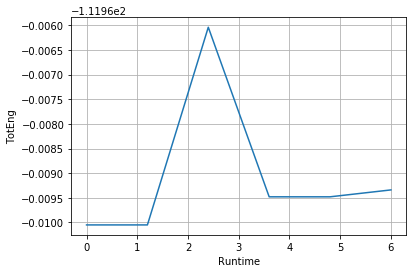

In [11]:
LA = LogAnalyzer(df)
LA.plotColumn('TotEng')


# Reading position vectors from dump files; Working DumpReader class



#implementation assumes that atom ids are in same order for each run, seems to be the case need to confirm 

In [152]:

class DumpReader:
    def __init__(self,filename, outputLabels = ''):
        self.filename = filename
        self.outputLabels = ('ITEM: ATOMS '+ outputLabels).split()
    
    def dataExtracter(self):
        dataLines = []         # format : [[rowData1], [rowData2], [rowData3], ... ]
        self.idLabels = ['Timestep']      # format : ['Timestep', 'atomID', 'atomID', ... ]
        rowData = []                      # format : [[timestep], [x,y,z], [x,y,z], ... ]
        
        f = open(self.filename,'r')
        isFirstRun = True
        isDataLine = False          # when initially set, line in next iteration is a data line
        isTimestepLine = False      # when initially set, line in next iteration is a timestep line
        timestep = 0
        
        for line in f.readlines():  
            if line.strip() == 'ITEM: TIMESTEP' or isTimestepLine:
                if isTimestepLine:
                    isTimestepLine = False
                    timestep = int(line.split()[0])
                    rowData.append([timestep])
                    if timestep > 0:                 #assumes simulation starts at 0 timestep
                        isFirstRun = False
                else:
                    isTimestepLine = True
            
            if isDataLine:  
                data = line.split()
                if len(line.split())!= 0 and data[0].isdigit():   
                    if isFirstRun: 
                        self.idLabels.append(data[0])   # append label
                    rowData.append(line.split()[1:])   
                else:
                    isDataLine = False
                    dataLines.append(rowData)
                    rowData = []
            
            if line.split() == self.outputLabels:    
                isDataLine = True                     
                
        f.close()
        return dataLines

    #User method to get dataframe from log data
    def getDataframe(self):
        return pd.DataFrame(self.dataExtracter(),columns=self.idLabels)
    
    def getNdArray(self):
        data = self.dataExtracter()
        for row in range(len(data)):
            #data[row] = np.array(data[row])
            for col in range(len(data[row])):
                data[row][col] = np.array(data[row][col]).astype(float)
        return np.array(data)
'''
note, tried to build dataLines as np.array but since i consistently appending new data to rowData i 
have to make a new copy and reassign (very wasteful) 
instead trying building dataLines then converting elements to np.array by looping, (is there a more efficient
way to do this?)

'''


'\nnote, tried to build dataLines as np.array but since i consistently appending new data to rowData i \nhave to make a new copy and reassign (very wasteful) \ninstead trying building dataLines then converting elements to np.array by looping, (is there a more efficient\nway to do this?)\n\n'

code for testing/proof of concept 

In [153]:
names = ['Timestep','1r','2r','3r']
a = [[[10],[1,2,3],[1,2,3],[1,2,3]],
         [[20],[1,2,3],[1,2,3],[1,2,3]],
         [[30],[1,2,3],[1,2,3],[1,2,3]],
         [[40],[1,2,3],[1,2,3],[1,2,3]]]
ar = np.array([[[10],[1,2,3],[1,2,3],[1,2,3]],
         [[20],[1,2,3],[1,2,3],[1,2,3]],
         [[30],[1,2,3],[1,2,3],[1,2,3]],
         [[40],[1,2,3],[1,2,3],[1,2,3]]])
pd.DataFrame(ar,columns = names)

ar2 = np.array([])

for row in a:
    r = np.array([])
    for elem in row:
        np.append(r,np.array(elem))
        
    np.append(ar2,r)



In [157]:
#outputLabels = 'id x y z'
DR = DumpReader('pos.XYZ','id x y z')
print(DR.getDataframe())


     Timestep                            1                             2  \
0         [0]                    [0, 0, 0]             [2.023, 2.023, 0]   
1        [10]                    [0, 0, 0]             [2.023, 2.023, 0]   
2        [20]                    [0, 0, 0]             [2.023, 2.023, 0]   
3        [30]                    [0, 0, 0]             [2.023, 2.023, 0]   
4        [40]                    [0, 0, 0]             [2.023, 2.023, 0]   
5        [50]                    [0, 0, 0]             [2.023, 2.023, 0]   
6        [60]                    [0, 0, 0]             [2.023, 2.023, 0]   
7        [70]                    [0, 0, 0]             [2.023, 2.023, 0]   
8        [80]                    [0, 0, 0]             [2.023, 2.023, 0]   
9        [90]                    [0, 0, 0]             [2.023, 2.023, 0]   
10      [100]                    [0, 0, 0]             [2.023, 2.023, 0]   
11      [110]                    [0, 0, 0]             [2.023, 2.023, 0]   
12      [120

# Edditable DumpReader2 class to implemented data extraction using ndarrays


In [64]:

class DumpReader2:
    def __init__(self,filename, outputLabels = ''):
        self.filename = filename
        self.outputLabels = ('ITEM: ATOMS '+ outputLabels).split()
    
    def dataExtracter(self):
        dataLines = []         # format : [[rowData1], [rowData2], [rowData3], ... ]
        self.idLabels = ['Timestep']      # format : ['Timestep', 'atomID', 'atomID', ... ]
        rowData = []                      # format : [[timestep], [x,y,z], [x,y,z], ... ]
        
        f = open(self.filename,'r')
        isFirstRun = True
        isDataLine = False          # when initially set, line in next iteration is a data line
        isTimestepLine = False      # when initially set, line in next iteration is a timestep line
        timestep = 0
        
        for line in f.readlines():  
            if line.strip() == 'ITEM: TIMESTEP' or isTimestepLine:
                if isTimestepLine:
                    isTimestepLine = False
                    timestep = int(line.split()[0])
                    rowData.append([timestep])
                    if timestep > 0:                 #assumes simulation starts at 0 timestep
                        isFirstRun = False
                else:
                    isTimestepLine = True
            
            if isDataLine:  
                data = line.split()
                if len(line.split())!= 0 and data[0].isdigit():   
                    if isFirstRun: 
                        self.idLabels.append(data[0])   # append label
                    rowData.append(line.split()[1:])   
                else:
                    isDataLine = False
                    dataLines.append(rowData)
                    rowData = []
            
            if line.split() == self.outputLabels:    
                isDataLine = True                     
                
        f.close()
        return dataLines

    #User method to get dataframe from log data
    def getDataframe(self):
        return pd.DataFrame(self.dataExtracter(),columns=self.idLabels)
    
    def getNdArray(self):
        return self.dataExtracter()
        



In [87]:
r = [[1],[1,2,3],[1,2,3]]
a = np.empty(0)
a = np.append(a,np.array([1,2,3]))
b = np.asarray(r)
for i in range(len(b)):
    b[i] = np.array(b[0])
    
print(b)

[array([1]) array([1]) array([1])]
